# Word embeddings for nucleotide tokens

In [214]:
import numpy as np
import pandas as pd
import sklearn, pickle
import sentencepiece as sp
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
import itertools

import word2vec_models as wv

import importlib
importlib.reload(wv) # reload wv if its already loaded

<module 'word2vec_models' from '/Users/matthiastreder/git/gen-attribution/word2vec_models.py'>

In [215]:
datadir = '/Users/matthiastreder/data/deeplearn/genetic-engineering-attribution-challenge/'
resultsdir = datadir + '/results/'

## Preprocess encoded data

In [167]:
!ls /Users/matthiastreder/data/deeplearn/genetic-engineering-attribution-challenge/

m1000.model                results
m1000.vocab                test_values.csv
m5000.model                train_labels.csv
m5000.vocab                train_values.csv
m800.model                 word2vec_train_data.pickle
m800.vocab


In [168]:
train = pd.read_csv(datadir+'train_values.csv')
train.head()

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
# encode tokens as integers
vocab = 1000
sp_model = sp.SentencePieceProcessor(model_file=datadir + f'm{vocab}.model')
encoded = [sp_model.encode(seq) for seq in train.sequence]
lens = [len(enc) for enc in encoded]
print('Encoded as', sp_model.vocab_size(), 'integers')

del sp_model

Encoded as 1000 integers


In [225]:
# for efficiency we concatenate all the sequences into one array and pad the borders with -1's
pad = 2
encoded = [[-1]*pad + enc + [-1]*pad for enc in encoded]

# flatten and convert to numpy
encoded = np.array(list(itertools.chain(*encoded)), dtype=np.int16)

Text(0.5, 1.0, 'Histogram of token frequencies')

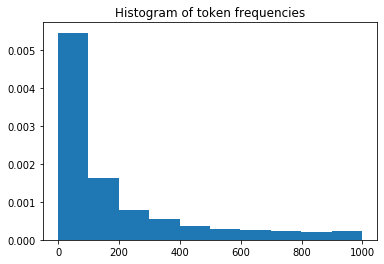

In [226]:
plt.hist(encoded, density=True)
plt.title('Histogram of token frequencies')

In [227]:
# relative frequencies
un = np.unique(encoded)
rel_freq = np.array([np.count_nonzero(encoded==u) for u in un])/len(encoded)

In [228]:
t = 0.0001
print(f'Number of tokens with freq > {t} (they get subsampled): {np.count_nonzero(rel_freq > t)}/{len(un)}')

discard_probabilities = wv.get_discard_probabilities_from_labels(encoded, t=t)
discard_probabilities[encoded==-1] = 1  # we never want the padded -1's to be selected as targets

Number of tokens with freq > 0.0001 (they get subsampled): 891/995


In [229]:
# replace the -1's by mirroring the sequence, e.g.
# 2, 3, 5, -1, -1  ->  2, 3, 5, 3, 2
pos = 0
for le in lens:
    encoded[pos:pos+pad] = encoded[pos+pad+pad:pos+pad:-1] # fill up -1's at the left border
    encoded[pos+le+pad:pos+le+2*pad] = encoded[pos+le+pad-2:pos+le-2:-1] # fill up -1's at the right border
    pos += le + 2*pad

In [230]:
# # COUNT THE NUMBER OF OCCURRENCES OF EACH TOKEN OVERALL (FOR SUBSAMPLING)
# # build list of dictionaries. Each dict contains the counts for the tokens in the respective sequence
# count_lists = [{key : value for key, value in Counter(enc).items()} for enc in encoded]

# # add counts across all sequences
# count = defaultdict(int)
# for count_list in count_lists:
#     for key, value in count_list.items():
#         count[key] += value

In [231]:
# this is nice but too inefficient
# # dictionary mapping a token to all positions where it appears in the data. a position is a tuple 
# # (i, j) where i is the i-th sequence and j is the j-th position within that sequence
# pos = defaultdict(list)
# for ix, enc in enumerate(encoded):
#     for u in np.unique(enc):
#         pos[u].extend((ix, z) for z in np.where(enc == u)[0])

In [232]:
# distribution for sampling negative targets in Skipgram
negative_sampling_distribution = wv.get_negative_sampling_distribution(encoded)

In [233]:
with open(resultsdir + f'word2vec_train_data_vocab{vocab}.pickle', 'wb') as f:
    pickle.dump((encoded, discard_probabilities, t, negative_sampling_distribution), f)